<a href="https://colab.research.google.com/github/RubiJimenez929/Machine-Learning/blob/main/Simulaci%C3%B3n_Embalses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset generado con 292000 transiciones.
Entrenando política con Fitted Q-Iteration...
Iteración 50 completada.
Iteración 100 completada.
Iteración 150 completada.
Simulando política aprendida...

Resultados de simulación (5 años):
- Días con riesgo de inundación: 341
- Déficit total acumulado: 2526.59


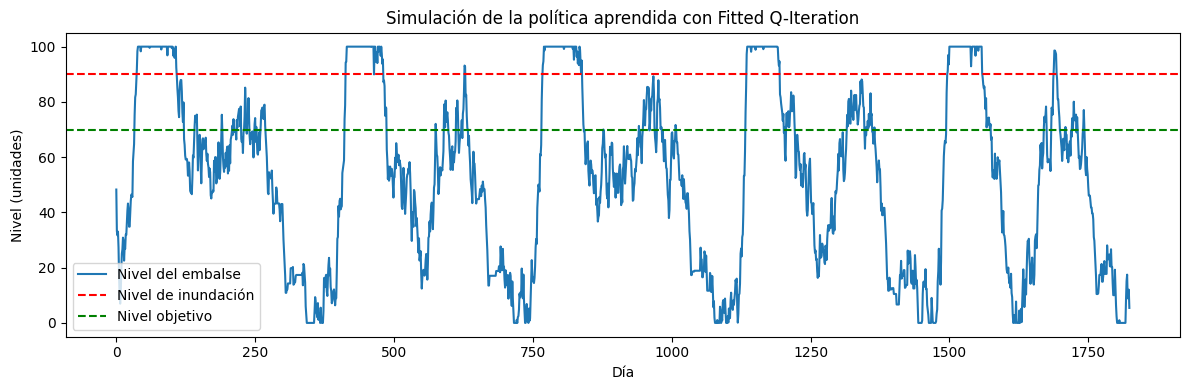

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

# ----------------------------
# 1. Parámetros del sistema
# ----------------------------
T = 365                     # días en un año
gamma = 0.999               # factor de descuento
n_years = 10                # años de datos sintéticos
storage_capacity = 100.0    # capacidad máxima del embalse (unidades arbitrarias)
target_level = 70.0         # nivel deseado (para evitar déficit)
flood_level = 90.0          # nivel de inundación

# ----------------------------
# 2. Generar inflow (entrada de agua) sintético con estacionalidad
# ----------------------------
def generate_inflow(t, noise_std=5.0):
    """Inflow con picos en primavera y otoño."""
    seasonal = 10 + 8 * np.sin(2 * np.pi * t / 365) + 6 * np.sin(4 * np.pi * t / 365) #estacionalidad
    noise = np.random.normal(0, noise_std) #v.a (ruido)
    return max(0, seasonal + noise)

# ----------------------------
# 3. Función de recompensa (costo)
# ----------------------------
def reward(storage, release, demand=8.0):
    """Recompensa negativa (costo): penaliza inundación y déficit."""
    flood_penalty = 10.0 if storage > flood_level else 0.0
    deficit_penalty = max(0, demand - release)  # déficit si no se libera suficiente
    return -(flood_penalty + deficit_penalty)

# ----------------------------
# 4. Generar conjunto de datos de transiciones (dataset de experiencia)
# ----------------------------
states = []
actions = []
next_states = []
rewards = []

demand = 8.0 #demanda de agua diaria promedio.
release_options = np.linspace(0, 15, 8)  # 8 decisiones posibles (genera valores igualmente espaciados entre 0 y 15, en este caso 8 valores.)
storage_grid = np.linspace(0, storage_capacity, 10)  # 10 niveles discretos

for year in range(n_years):
    inflow_series = [generate_inflow(t) for t in range(T)]
    for t in range(T):
        for s in storage_grid:
            for u in release_options:
                # Estado actual
                state = np.array([t, s])
                # Aplicar balance hídrico
                inflow = inflow_series[t]
                actual_release = min(u, s + inflow)  # no se puede liberar más de lo disponible
                next_storage = min(storage_capacity, max(0, s + inflow - actual_release))
                # Recompensa
                r = reward(s, actual_release, demand)
                # Estado siguiente
                next_state = np.array([(t + 1) % T, next_storage])
                # Guardar transición
                states.append(state)
                actions.append(u)
                next_states.append(next_state)
                rewards.append(r)

# Convertir a arrays
states = np.array(states)
actions = np.array(actions)
next_states = np.array(next_states)
rewards = np.array(rewards)

# Crear dataset de 4-tuplas: (s, a, s', r)
X = np.hstack([states, actions.reshape(-1, 1)])  # [t, s, a]
y = rewards

print(f"Dataset generado con {len(X)} transiciones.")

# ----------------------------
# 5. Fitted Q-Iteration con ExtraTrees
# ----------------------------
  def fitted_q_iteration(X, next_states, rewards, n_iterations=150):
      Q = np.zeros(len(X))  # inicialización
      model = None

      for h in range(1, n_iterations + 1):
          # Construir objetivo: r + gamma * max_a' Q(s', a')
          if h == 1:
              target = rewards
          else:
              # Evaluar Q(s', a') para todas las acciones posibles
              next_Q_vals = [] #Lista vacía para guardar los valores Q(s', a')
              for a in release_options:
                  next_X = np.hstack([next_states, np.full((len(next_states), 1), a)])
                  pred = model.predict(next_X)
                  next_Q_vals.append(pred)
              next_Q_vals = np.max(np.array(next_Q_vals), axis=0)
              target = rewards + gamma * next_Q_vals # "Ec. Bellman"

          # Entrenar nuevo modelo Q
          model = ExtraTreesRegressor(n_estimators=30, min_samples_leaf=15, random_state=42) #f_{θ_h}​​
          model.fit(X, target)

          if h % 50 == 0:
              print(f"Iteración {h} completada.")

      return model

print("Entrenando política con Fitted Q-Iteration...")
Q_model = fitted_q_iteration(X, next_states, rewards, n_iterations=150)

# ----------------------------
# 6. Simular política aprendida
# ----------------------------
def simulate_policy(model, n_sim_years=5):
    storage_hist = []
    release_hist = []
    flood_days = 0
    total_deficit = 0

    s = 50.0  # nivel inicial
    for year in range(n_sim_years):
        inflow_series = [generate_inflow(t) for t in range(T)]
        for t in range(T):
            # Evaluar Q(s,a) para todas las acciones
            q_vals = []
            for a in release_options:
                x = np.array([[t, s, a]])
                q_vals.append(model.predict(x)[0])
            best_a = release_options[np.argmax(q_vals)]
            # Aplicar decisión
            inflow = inflow_series[t]
            actual_release = min(best_a, s + inflow)
            s = min(storage_capacity, max(0, s + inflow - actual_release))
            # Registrar
            storage_hist.append(s)
            release_hist.append(actual_release)
            if s > flood_level:
                flood_days += 1
            total_deficit += max(0, demand - actual_release)

    return storage_hist, release_hist, flood_days, total_deficit

print("Simulando política aprendida...")
storage_hist, _, flood_days, total_deficit = simulate_policy(Q_model)

print(f"\nResultados de simulación ({5} años):")
print(f"- Días con riesgo de inundación: {flood_days}")
print(f"- Déficit total acumulado: {total_deficit:.2f}")

# ----------------------------
# 7. Visualización
# ----------------------------
plt.figure(figsize=(12, 4))
plt.plot(storage_hist, label='Nivel del embalse')
plt.axhline(flood_level, color='red', linestyle='--', label='Nivel de inundación')
plt.axhline(target_level, color='green', linestyle='--', label='Nivel objetivo')
plt.xlabel('Día')
plt.ylabel('Nivel (unidades)')
plt.title('Simulación de la política aprendida con Fitted Q-Iteration')
plt.legend()
plt.tight_layout()
plt.show()

Dataset generado con 292000 transiciones.
Entrenando política con Fitted Q-Iteration...
Iteración 50 completada.
Iteración 100 completada.
Iteración 150 completada.
Simulando política aprendida...

Resultados de simulación (5 años):
- Días con riesgo de inundación: 350
- Déficit total acumulado: 2491565.81 m³


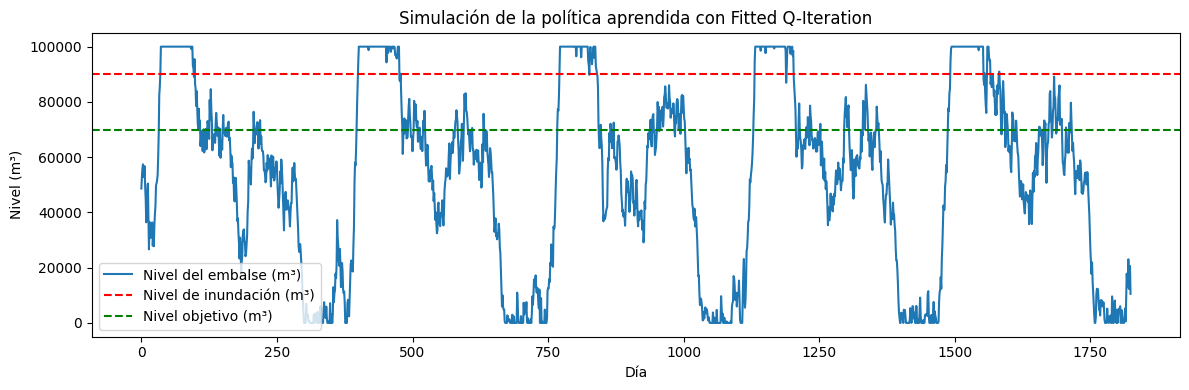

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

# ----------------------------
# 1. Parámetros del sistema (escalados a m³)
# ----------------------------
escala = 1000  # 1 unidad = 1000 m³

T = 365 # días en un año
gamma = 0.999 # factor de descuento
n_years = 10 # años de datos sintéticos

storage_capacity = 100.0 * escala       # 100,000 m³ capacidad máxima del embalse
target_level = 70.0 * escala            # 70,000 m³ nivel deseado (para evitar déficit)
flood_level = 90.0 * escala             # 90,000 m³ nivel de inundación
demand = 8.0 * escala                   # 8000 m³/día

release_options = np.linspace(0, 15, 8) * escala  # 0 a 15,000 m³/día #8 decisiones posibles
storage_grid = np.linspace(0, storage_capacity, 10) #10 niveles discretos

# ----------------------------
# 2. Generar inflow (entrada de agua) sintético con estacionalidad
# ----------------------------
def generate_inflow(t, noise_std=5.0 * escala):
    seasonal = (10 + 8 * np.sin(2 * np.pi * t / 365) + 6 * np.sin(4 * np.pi * t / 365)) * escala
    noise = np.random.normal(0, noise_std)
    return max(0, seasonal + noise)

# ----------------------------
# 3. Función de recompensa (costo)
# ----------------------------
def reward(storage, release, demand=demand):
    flood_penalty = 10.0 if storage > flood_level else 0.0
    deficit_penalty = max(0, demand - release) / escala  # penalización en unidades
    return -(flood_penalty + deficit_penalty)

# ----------------------------
# 4. Generar conjunto de datos de transiciones (dataset de experiencia)
# ----------------------------
states = []
actions = []
next_states = []
rewards = []

for year in range(n_years):
    inflow_series = [generate_inflow(t) for t in range(T)]
    for t in range(T):
        for s in storage_grid:
            for u in release_options:
                # Estado actual
                state = np.array([t, s])
                # Aplicar balance hídrico
                inflow = inflow_series[t]
                actual_release = min(u, s + inflow)
                next_storage = min(storage_capacity, max(0, s + inflow - actual_release))
                # Recompensa
                r = reward(s, actual_release, demand)
                next_state = np.array([(t + 1) % T, next_storage])
                #Guardar transición
                states.append(state)
                actions.append(u)
                next_states.append(next_state)
                rewards.append(r)

#Convertir a arrays
states = np.array(states)
actions = np.array(actions)
next_states = np.array(next_states)
rewards = np.array(rewards)

X = np.hstack([states, actions.reshape(-1, 1)])
y = rewards

print(f"Dataset generado con {len(X)} transiciones.")

# ----------------------------
# 5. Fitted Q-Iteration con ExtraTrees
# ----------------------------
def fitted_q_iteration(X, next_states, rewards, n_iterations=150):
    Q = np.zeros(len(X))
    model = None

    for h in range(1, n_iterations + 1):
        if h == 1:
            target = rewards
        else:
            next_Q_vals = []
            for a in release_options:
                next_X = np.hstack([next_states, np.full((len(next_states), 1), a)])
                pred = model.predict(next_X)
                next_Q_vals.append(pred)
            next_Q_vals = np.max(np.array(next_Q_vals), axis=0)
            target = rewards + gamma * next_Q_vals

        model = ExtraTreesRegressor(n_estimators=30, min_samples_leaf=15, random_state=42)
        model.fit(X, target)

        if h % 50 == 0:
            print(f"Iteración {h} completada.")

    return model

print("Entrenando política con Fitted Q-Iteration...")
Q_model = fitted_q_iteration(X, next_states, rewards, n_iterations=150)

# ----------------------------
# 6. Simular política aprendida
# ----------------------------
def simulate_policy(model, n_sim_years=5):
    storage_hist = []
    release_hist = []
    flood_days = 0
    total_deficit = 0

    s = 50.0 * escala  # nivel inicial = 50,000 m³
    for year in range(n_sim_years):
        inflow_series = [generate_inflow(t) for t in range(T)]
        for t in range(T):
            q_vals = []
            for a in release_options:
                x = np.array([[t, s, a]])
                q_vals.append(model.predict(x)[0])
            best_a = release_options[np.argmax(q_vals)]
            inflow = inflow_series[t]
            actual_release = min(best_a, s + inflow)
            s = min(storage_capacity, max(0, s + inflow - actual_release))
            storage_hist.append(s)
            release_hist.append(actual_release)
            if s > flood_level:
                flood_days += 1
            total_deficit += max(0, demand - actual_release)

    return storage_hist, release_hist, flood_days, total_deficit

print("Simulando política aprendida...")
storage_hist, _, flood_days, total_deficit = simulate_policy(Q_model)

print(f"\nResultados de simulación ({5} años):")
print(f"- Días con riesgo de inundación: {flood_days}")
print(f"- Déficit total acumulado: {total_deficit:.2f} m³")

# ----------------------------
# 7. Visualización
# ----------------------------
plt.figure(figsize=(12, 4))
plt.plot(storage_hist, label='Nivel del embalse (m³)')
plt.axhline(flood_level, color='red', linestyle='--', label='Nivel de inundación (m³)')
plt.axhline(target_level, color='green', linestyle='--', label='Nivel objetivo (m³)')
plt.xlabel('Día')
plt.ylabel('Nivel (m³)')
plt.title('Simulación de la política aprendida con Fitted Q-Iteration')
plt.legend()
plt.tight_layout()
plt.show()